Proceeding stitching Radargram Data_20120507_07_004.mat and Radargram Data_20120507_07_005.mat...
Proceeding stitching Radargram Data_20120507_07_005.mat and Radargram Data_20120507_07_006.mat...
Proceeding stitching Radargram Data_20120507_07_006.mat and Radargram Data_20120507_07_007.mat...
Proceeding stitching Radargram Data_20120507_07_007.mat and Radargram Data_20120507_07_008.mat...
Proceeding stitching Radargram Data_20120507_07_008.mat and Radargram Data_20120507_07_009.mat...
Proceeding stitching Radargram Data_20120507_07_009.mat and Radargram Data_20120507_07_010.mat...
Proceeding stitching Radargram Data_20120507_07_010.mat and Radargram Data_20120507_07_011.mat...
Proceeding stitching Radargram Data_20120507_07_011.mat and Radargram Data_20120507_07_012.mat...
Number of layers in the stitched mask: 305
Number of layers spanning 2 masks: 101.0
Number of layers spanning 3 masks: 37.0
Number of layers spanning 4 masks: 19.0
Number of layers spanning 5 masks: 10.0
Number of la

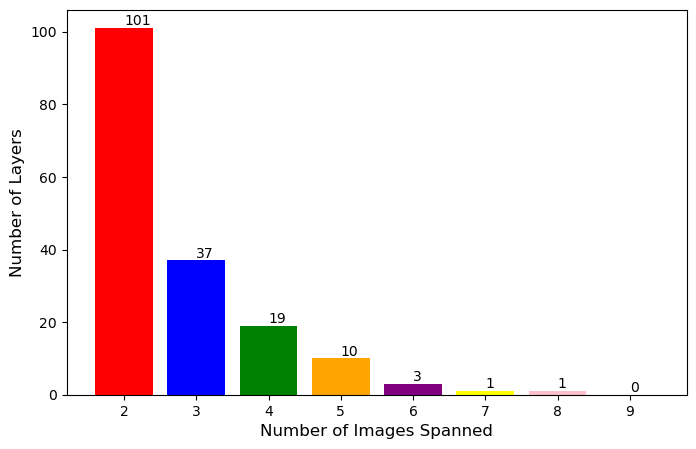

In [1]:
import glob
import os
from load_and_process_radargram import load_and_process_radargram, load_lat_lon, load_log_gps_time
from find_overlap import find_overlapping_columns,find_overlapping_intervals,adjust_overlapping_intervals
from stitch_masks import stitch_masks
from find_and_follow_layer import find_layers, follow_layer
from calculate_continous_layer import calculate_continuous_layers
from generate_data_files import generate_data_files
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

radar_dir = './raw-radargram-mat/'
file_pattern = os.path.join(radar_dir, '*.mat')
mat_files = glob.glob(file_pattern)

data_files = generate_data_files('Data_20120507_07_', 4, 12)
radar_data_prev, ground_truth_mask_prev, depth_data_prev = load_and_process_radargram(data_files[0], "./expert-layer-data-mat/Layer_", './raw-radargram-mat/')
stitched_mask = ground_truth_mask_prev

manual_vertical_shifts = [-26, -42, -55, -57, -53, -39, -19, 9]

for i in range(1, len(data_files)):
    print(f"Proceeding stitching Radargram {data_files[i - 1]} and Radargram {data_files[i]}...")

    radar_data_curr, ground_truth_mask_curr, depth_data_curr = load_and_process_radargram(data_files[i], "./expert-layer-data-mat/Layer_", './raw-radargram-mat/')    
    log_gps_time_prev = load_log_gps_time('./raw-radargram-mat/' + data_files[i - 1])
    log_gps_time_curr = load_log_gps_time('./raw-radargram-mat/' + data_files[i])    
    
    lat_prev, lon_prev = load_lat_lon('./raw-radargram-mat/' + data_files[i - 1])
    lat_curr, lon_curr = load_lat_lon('./raw-radargram-mat/' + data_files[i])
    
    overlap_idx_prev, overlap_idx_curr = find_overlapping_intervals(log_gps_time_prev, log_gps_time_curr)
    col_overlap_idx_prev, col_overlap_idx_curr = find_overlapping_columns(lat_prev, lon_prev, lat_curr, lon_curr)
    
    if col_overlap_idx_prev != (None, None) and col_overlap_idx_curr != (None, None):
        overlap_idx_prev = [(max(overlap_idx_prev[0][0], col_overlap_idx_prev[0]), min(overlap_idx_prev[0][1], col_overlap_idx_prev[1]))]
        overlap_idx_curr = [(max(overlap_idx_curr[0][0], col_overlap_idx_curr[0]), min(overlap_idx_curr[0][1], col_overlap_idx_curr[1]))]
    
    overlap_idx_prev, overlap_idx_curr = adjust_overlapping_intervals(overlap_idx_prev, overlap_idx_curr)
    
    try:
        stitched_mask = stitch_masks(stitched_mask, ground_truth_mask_curr, overlap_idx_prev, overlap_idx_curr, manual_vertical_shifts[i-1])
    except ValueError as e:
        print(f"Error stitching masks for files {data_files[i - 1]} and {data_files[i]}: {e}")
        break
    
    radar_data_prev = radar_data_curr
    ground_truth_mask_prev = ground_truth_mask_curr
    depth_data_prev = depth_data_curr

num_masks = len(data_files)
min_span = max([ground_truth_mask_prev.shape[1] for ground_truth_mask_prev in [ground_truth_mask_prev] + [ground_truth_mask_curr]]) + 1
continuous_layers_count = calculate_continuous_layers(stitched_mask, num_masks, min_span)

layers = find_layers(stitched_mask)
print("Number of layers in the stitched mask:", len(find_layers(stitched_mask)))

for n in range(2, num_masks + 1):
    print(f"Number of layers spanning {n} masks: {continuous_layers_count[n-2]}")
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'pink', 'cyan']
plt.figure(figsize=(8, 5))
bars = plt.bar(range(2, 10), continuous_layers_count[:8], color=colors[:8], tick_label=[str(i) for i in range(2, 10)])
plt.xlabel('Number of Images Spanned', fontsize=12)
plt.ylabel('Number of Layers', fontsize=12)
plt.savefig('areselp_hist.png', dpi=300, bbox_inches='tight')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom')
plt.show()